In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

不平衡数据的不同分布会对分类器产生不一样的影响，比如下方的分布，第一张图片正负样本比例很低(一般少数类称为正样本，多数类称为负样本)，但我们可以很容易的找到一条线将数据分割开，而第二张图片就很难了，虽然和第一张图的正负比例一样，但正负样本的重叠部分太多，很难分割，第三张图片中正负比例和第一张图也一样，但两类数据中都混入了不少噪声数据，给分类建模带来困难，第四张图片的正负比例也一样，但每个类内部又有2个簇（类内不平衡），增加建模难度

In [2]:
X1, y1 = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3, random_state=0)
X2, y2 = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=0.9, random_state=0)
X3, y3 = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,weights=[0.05, 0.95],
                           class_sep=3,flip_y=0.1, random_state=0)
X4, y4 = make_classification(n_samples=500, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=2,weights=[0.05, 0.95],
                           class_sep=3.0,random_state=0)

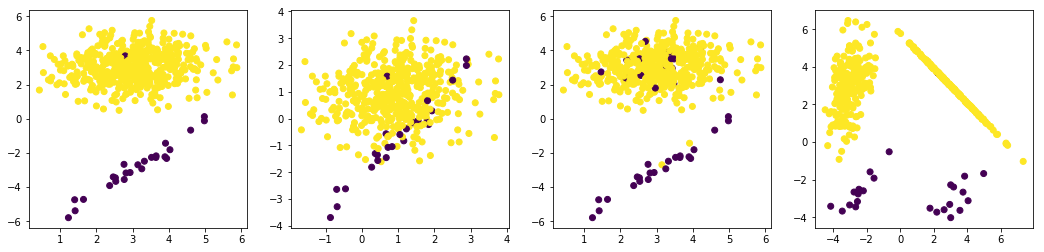

In [3]:
plt.figure(figsize = (18,4))
plt.subplot(1,4,1)
plt.scatter(x=X1[:,0],y=X1[:,1],c=y1)
plt.subplot(1,4,2)
plt.scatter(x=X2[:,0],y=X2[:,1],c=y2)
plt.subplot(1,4,3)
plt.scatter(x=X3[:,0],y=X3[:,1],c=y3)
plt.subplot(1,4,4)
plt.scatter(x=X4[:,0],y=X4[:,1],c=y4)

所以，在对不平衡数据建模时，我们不仅需要考虑正负样本的比例，还要考虑其他的影响因素，并尽可能对其进行量化；对分布的不同指标的直观理解，有利于后续的处理方法选择以及模型选择，总的来说，影响因素包括这些：类别不平衡比率、重叠区域大小、训练样本的绝对数量、类内不平衡程度、噪声样本比率、样本维度、离群点等

### 1.类别不平衡比率
这个是最常用的指标，假设正样本数量为$N_+$，负样本数量为$N_-$，则不平衡比率为$IR=\frac{N_-}{N_+}$
### 2.重叠区域大小
该区域可以通过$k$近邻的点来看，如果与某一样本点相距最近的$k$个样本点中，既包含同类样本点，又包含异类样本点，可将该样本点视作处于重叠区域
### 3.训练样本的绝对数量
训练样本的绝对数量也是一个很重要的指标，如果绝对数量过小，则所有训练样本可以视作整体样本的一个随机抽样，这里会引入偏差
### 4.类内不平衡程度
类内不平衡程度是指正样本可能还有多个簇（这无疑雪上加霜，本来数据就少，还被分在了多个地方...），这可通过密度聚类的方式来评估
### 5.噪声样本比率
正样本中的噪声样本对建模的影响很大（如果后续采用了过采样一类的算法，还会进一步扩大其影响），同样可以通过$k$近邻的点来判断，如果某一个样本点周围都是异类样本点，可以将该点视作噪声样本
### 6.样本维度
样本维度也会存在一些影响，本来数据量就很少的正样本还被分散在了一个很高维的空间，无疑会增加建模的难度，这通常可以通过降维算法来降低维度，但如何“无损”降维需要更多的尝试
### 7.离群点
离群点也会对分类算法产生影响（不同的分类算法，影响程度不同），可以通过某样本点距离同类样本中心距离和平均距离做对比来评估  

这些影响因素中，我们需要重点关注**类别不平衡比例、重叠区域大小、类内不平衡程度、噪声样本比例**，下面构建一个类来对这些指标进行计算：

In [4]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
import pandas as pd


class ImbLearnUtils(object):
    def __init__(self, k=3):
        # 计算重叠区域和异常点所需的k
        self.k = k
        # 每个label包含的样本数
        self.label_map_num = {}
        # 正样本标签
        self.pos_label = None
        # 负样本标签
        self.neg_label = None
        # 类间不平衡率
        self.ir = None
        # 所有标签集合
        self.labels = None
        # 各样本最近k个样本的类别分布
        self.k_neighbors_dist = []
        # 记录该点是否在重叠区域
        self.overlap_marks = []
        # 记录该点是否是异常点
        self.abnormal_marks = []
        # 正样本密度聚类类别数
        self.pos_db_scan_classes = None
        # 负样本密度聚类类别数
        self.neg_db_scan_classes = None
        # 正样本中重叠量
        self.pos_and_overlap_nums = None
        # 负样本中重叠量
        self.neg_and_overlap_nums = None
        # 正样本中异常量
        self.pos_and_abn_nums = None
        # 负样本中异常量
        self.neg_and_abn_nums = None

    def fit(self, X, y):
        # 确定正类和负类
        tmp_labels = []
        tmp_nums = []
        self.labels = set(y)
        if (len(self.labels)) != 2:
            raise Exception("标签类别数:", len(self.labels))
        for y_label in self.labels:
            self.label_map_num[y_label] = np.sum(y == y_label)
            tmp_labels.append(y_label)
            tmp_nums.append(np.sum(y == y_label))
        if tmp_nums[0] < tmp_nums[1]:
            self.pos_label = tmp_labels[0]
            self.neg_label = tmp_labels[1]
        else:
            self.pos_label = tmp_labels[1]
            self.neg_label = tmp_labels[0]

        # 计算类间不平衡度
        self.ir = self.label_map_num[self.neg_label] / self.label_map_num[self.pos_label]
        # 计算每个样本的最近k个点的类别分布
        knn = KNeighborsClassifier(n_neighbors=self.k)
        knn.fit(X, y)
        distances = knn.kneighbors_graph().todense()
        for index in range(len(y)):
            indices = np.argwhere(np.asarray(distances[index]).reshape(-1) == 1).reshape(-1)
            self.k_neighbors_dist.append(y[indices].tolist())
        # 计算重叠区域和噪声
        for index in range(len(y)):
            label_set = set(self.k_neighbors_dist[index])
            # 该点附近既有正样本又有负样本
            if len(label_set) == 2:
                self.overlap_marks.append(1)
            else:
                self.overlap_marks.append(0)
            if len(label_set) == 1 and label_set.pop() != y[index]:
                self.abnormal_marks.append(1)
            else:
                self.abnormal_marks.append(0)
        self.overlap_marks = np.asarray(self.overlap_marks)
        self.abnormal_marks = np.asarray(self.abnormal_marks)

        self.pos_and_overlap_nums = np.sum((y == self.pos_label) * (self.overlap_marks == 1))
        self.neg_and_overlap_nums = np.sum((y == self.neg_label) * (self.overlap_marks == 1))

        self.pos_and_abn_nums = np.sum((y == self.pos_label) * (self.abnormal_marks == 1))
        self.neg_and_abn_nums = np.sum((y == self.neg_label) * (self.abnormal_marks == 1))

        # 计算类内的不平衡度
        self.pos_db_scan_classes = len(set(DBSCAN().fit(X[np.argwhere(y == self.pos_label).reshape(-1)]).labels_)) - 1
        self.neg_db_scan_classes = len(set(DBSCAN().fit(X[np.argwhere(y == self.neg_label).reshape(-1)]).labels_)) - 1

    def show(self):
        """
        展示各统计指标
        :return:
        """
        show_list = []
        show_list.append(['样本数量', self.label_map_num[self.pos_label], self.label_map_num[self.neg_label]])
        show_list.append(['重叠样本数', self.pos_and_overlap_nums, self.neg_and_overlap_nums])
        show_list.append(['异常样本数', self.pos_and_abn_nums, self.neg_and_abn_nums])
        show_list.append(['类内不平衡度', self.pos_db_scan_classes, self.neg_db_scan_classes])
        return pd.DataFrame(show_list, columns=['index_name', 'pos', 'neg'])

In [5]:
imbu=ImbLearnUtils()
imbu.fit(X1,y1)
imbu.show()

,index_name,pos,neg
0,样本数量,26,474
1,重叠样本数,2,4
2,异常样本数,1,0
3,类内不平衡度,1,1


In [6]:
imbu=ImbLearnUtils()
imbu.fit(X2,y2)
imbu.show()

,index_name,pos,neg
0,样本数量,26,474
1,重叠样本数,15,41
2,异常样本数,7,2
3,类内不平衡度,1,1


In [7]:
imbu=ImbLearnUtils()
imbu.fit(X3,y3)
imbu.show()

,index_name,pos,neg
0,样本数量,40,460
1,重叠样本数,9,38
2,异常样本数,15,2
3,类内不平衡度,3,1


In [8]:
imbu=ImbLearnUtils()
imbu.fit(X4,y4)
imbu.show()

,index_name,pos,neg
0,样本数量,27,473
1,重叠样本数,1,10
2,异常样本数,2,0
3,类内不平衡度,1,2
